# Este notebook a diferencia del otro en esta misma carpeta ya contiene la transformacion de las columnas del sentimiento integrado en el pipeline, se dan las dos opciones ya que entre con esta transformacion con o sin el pipeline la diferencia entre lo que se tarda es notablemente superior con esta tranformacion. Tambien encuentra un notebook para añadir estas columans por aparte a cualquier dataset.

# 0. Carga de datos y configuración del ambiente

In [65]:
!pip3 install pysentimiento

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ydata_profiling import ProfileReport
import scipy.stats as stats
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter
import re
import nltk
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from pysentimiento import create_analyzer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [67]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 50)
sns.set()

In [68]:
df = pd.read_csv('./train.csv', delimiter=';')

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57063 entries, 0 to 57062
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           57063 non-null  object
 1   Label        57063 non-null  int64 
 2   Titulo       57047 non-null  object
 3   Descripcion  57063 non-null  object
 4   Fecha        57063 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.2+ MB


In [70]:
df.sample(5)

,ID,Label,Titulo,Descripcion,Fecha
4800,ID,1,Ábalos exige a Rivera 'una disculpa pública' p...,El secretario de Organización del PSOE recuerd...,16/09/2018
21368,ID,0,Teresa Bueyes no ve 'bien' la ley de Memoria q...,El expresidente del Gobierno ha asegurado que ...,06/07/2022
48307,ID,1,Sánchez hace un llamamiento a todos los partid...,El presidente del Gobierno aboga por una recup...,26/08/2021
16261,ID,0,La Fiscalía pide excluir al Ayuntamiento de Ba...,Considera que el consistorio no fue ni ofendid...,05/04/2019
50467,ID,1,El abogado de Forn reconoce que desobedeció al...,"Cedo esa trinchera, afirma el letrado Xavier M...",11/06/2019


In [71]:
df.ID.value_counts()

ID
ID    57063
Name: count, dtype: int64

Tenemos una columna llamada ID pero en realidad no contiene ningún ID por lo que  no sería relevante ni para el dataframe ni para el análisis; la eliminaremos y dejaremos como indice el por defecto de pandas.

In [72]:
df.drop(columns=['ID'], inplace=True)
df.head()

,Label,Titulo,Descripcion,Fecha
0,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023
1,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023
2,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,25/04/2022
3,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022
4,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018


# 1. Entendimiento

## 1.1 Completitud

In [73]:
df.isna().sum()

Label           0
Titulo         16
Descripcion     0
Fecha           0
dtype: int64

In [74]:
df[df["Titulo"].isnull()]

,Label,Titulo,Descripcion,Fecha
3243,0,NaN,"Hace unos 75 años, Hermann Göring testificó en...",16/06/2019
4189,0,NaN,"Evidentemente, Barak Obama ha sido arrestado e...",10/03/2022
5041,0,NaN,"""Después de convertirme en presidente, le pedí...",16/03/2022
5644,0,NaN,Me pasaron de buena fuente hoy (un vecino del ...,08/04/2023
7345,0,NaN,Defienden dichos con capitulos de Don Gato.\n\...,02/07/2023
7652,0,NaN,Lean (y vean la imagen) con mucha atención:\n\...,04/08/2018
9700,0,NaN,¿Sabías que Francisco Sagasti salió a marchar ...,26/12/2018
15159,0,NaN,Declarar a Bill Gates enemigo público y proces...,02/08/2024
19415,0,NaN,Con el fin de captar votos están dispuestos a ...,28/10/2017
24806,0,NaN,CUANDO LAS IMÁGENES HABLAN MÁS QUE PALABRAS.\n...,28/06/2018


Tenemos nulos en la columna titulo, imputaremos estos valores con la pimera parte de la descripción de la noticia.

In [75]:
def replace_nan_with_description(df):
    for index, row in df.iterrows():
        if pd.isna(row['Titulo']):
            description = row['Descripcion']
            if isinstance(description, str):
                first_sentence = description.split('.')[0]
                df.at[index, 'Titulo'] = first_sentence
    return df

df = replace_nan_with_description(df)
df.isna().sum()

Label          0
Titulo         0
Descripcion    0
Fecha          0
dtype: int64

Ya no tenemos nulos.

## 1.2 Unicidad

In [76]:
len(df[df.duplicated(keep='last')])

445

Tenemos 445 registros duplicados, los eliminaremos dejando solo el original para solucionar la unicidad.

In [77]:
df.drop_duplicates(inplace=True)
len(df[df.duplicated(keep='last')])

0

Ya no tenemos problemas de unicidad.

## 1.3 Consistencia

In [78]:
df['Label'].value_counts()

Label
1    32738
0    23880
Name: count, dtype: int64

La columna `Label` es consistente.

In [79]:
def verify_fecha_format(df):
    try:
        pd.to_datetime(df['Fecha'], format='%d/%m/%Y')
        print("Todas las fechas siguen el formato DD/MM/YYYY.")
    except ValueError as e:
        print("Hay fechas que no siguen el formato DD/MM/YYYY.")
        print(e)

verify_fecha_format(df)

Todas las fechas siguen el formato DD/MM/YYYY.


## 1.4 Validez

In [80]:
def verify_fecha_constraints(df):
    invalid_dates = []
    for date in df['Fecha']:
        try:
            day, month, year = map(int, date.split('/'))
            if not (1 <= day <= 31 and 1 <= month <= 12 and year <= 2025):
                invalid_dates.append(date)
        except ValueError:
            invalid_dates.append(date)

    if invalid_dates:
        print("Las siguientes fechas nos son validas:")
        print(invalid_dates)
    else:
        print("Todas las fechas son validas.")

verify_fecha_constraints(df)

Todas las fechas son validas.


## 1.4 Visualización

Text(0.5, 1.0, 'Cantidad de noticias falsas y verdaderas')

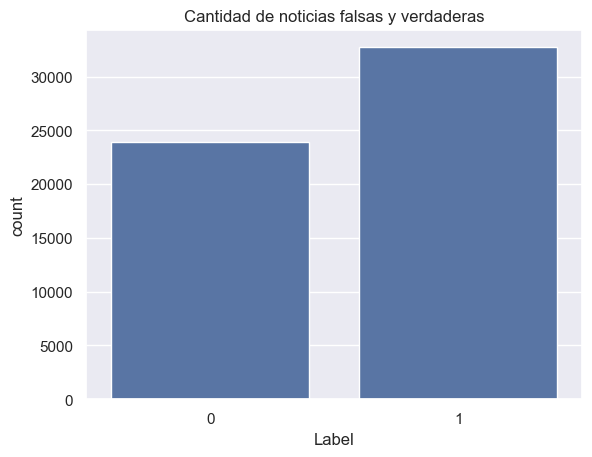

In [81]:
sns.countplot(x=df['Label'])
plt.title('Cantidad de noticias falsas y verdaderas')

Aunque el balance de los datos no es un balance perfecto, tampoco es un desbalance extremo.

In [82]:
top_10_dates = df['Fecha'].value_counts().head(20)
top_10_dates

Fecha
29/05/2023    89
27/05/2019    83
24/04/2019    71
18/07/2019    70
29/04/2019    69
05/06/2019    68
18/11/2019    68
10/01/2020    67
14/06/2018    66
26/02/2019    66
28/02/2019    64
17/01/2019    64
18/06/2018    64
03/10/2019    63
27/11/2019    62
11/04/2019    62
16/02/2021    62
15/03/2021    60
09/05/2019    60
19/02/2019    60
Name: count, dtype: int64

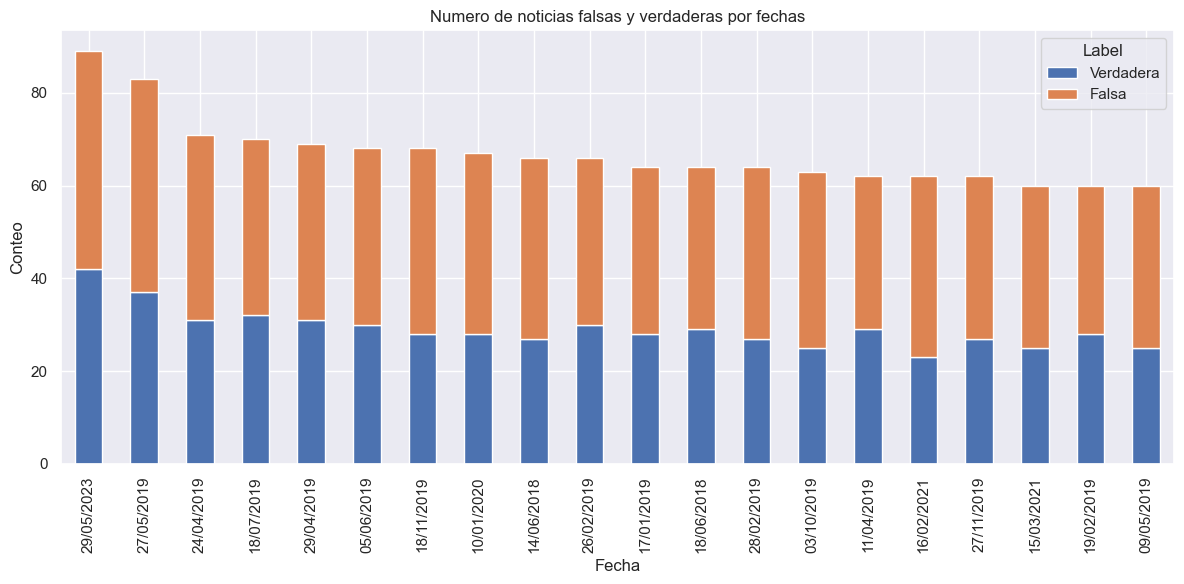

In [83]:
top_20_dates = top_10_dates.index
df_top_20_dates = df[df['Fecha'].isin(top_20_dates)]

news_per_date = df_top_20_dates.groupby(['Fecha', 'Label']).size().unstack(fill_value=0)
news_per_date_sorted = news_per_date.loc[news_per_date.sum(axis=1).sort_values(ascending=False).index]

plt.figure(figsize=(12, 6))
news_per_date_sorted.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Numero de noticias falsas y verdaderas por fechas')
plt.xlabel('Fecha')
plt.ylabel('Conteo')
plt.legend(title='Label', labels=['Verdadera', 'Falsa'])
plt.tight_layout()
plt.show()

In [84]:
df['Titulo_length'] = df['Titulo'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
df['Descripcion_length'] = df['Descripcion'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)

titulo_stats = df['Titulo_length'].describe()
descripcion_stats = df['Descripcion_length'].describe()

print("Estadisticas generales sobre la longitud del titulo:")
print(titulo_stats)
print("\nEstadisticas generales sobre la longitud de la descripción:")
print(descripcion_stats)

Estadisticas generales sobre la longitud del titulo:
count    56618.000000
mean        16.141351
std          3.972857
min          1.000000
25%         13.000000
50%         16.000000
75%         19.000000
max         54.000000
Name: Titulo_length, dtype: float64

Estadisticas generales sobre la longitud de la descripción:
count    56618.000000
mean        40.286888
std         45.020780
min          4.000000
25%         28.000000
50%         36.000000
75%         45.000000
max       2470.000000
Name: Descripcion_length, dtype: float64


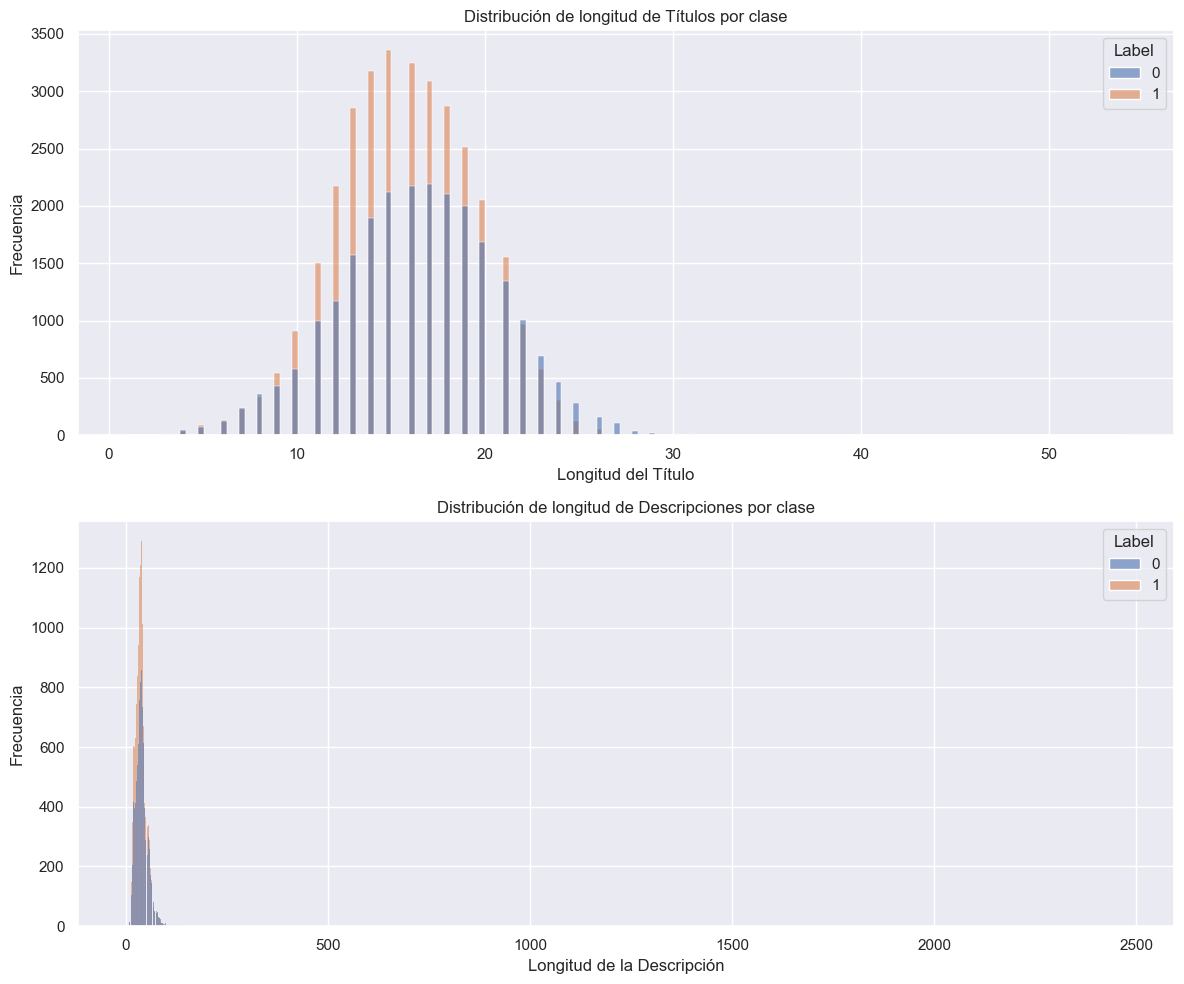

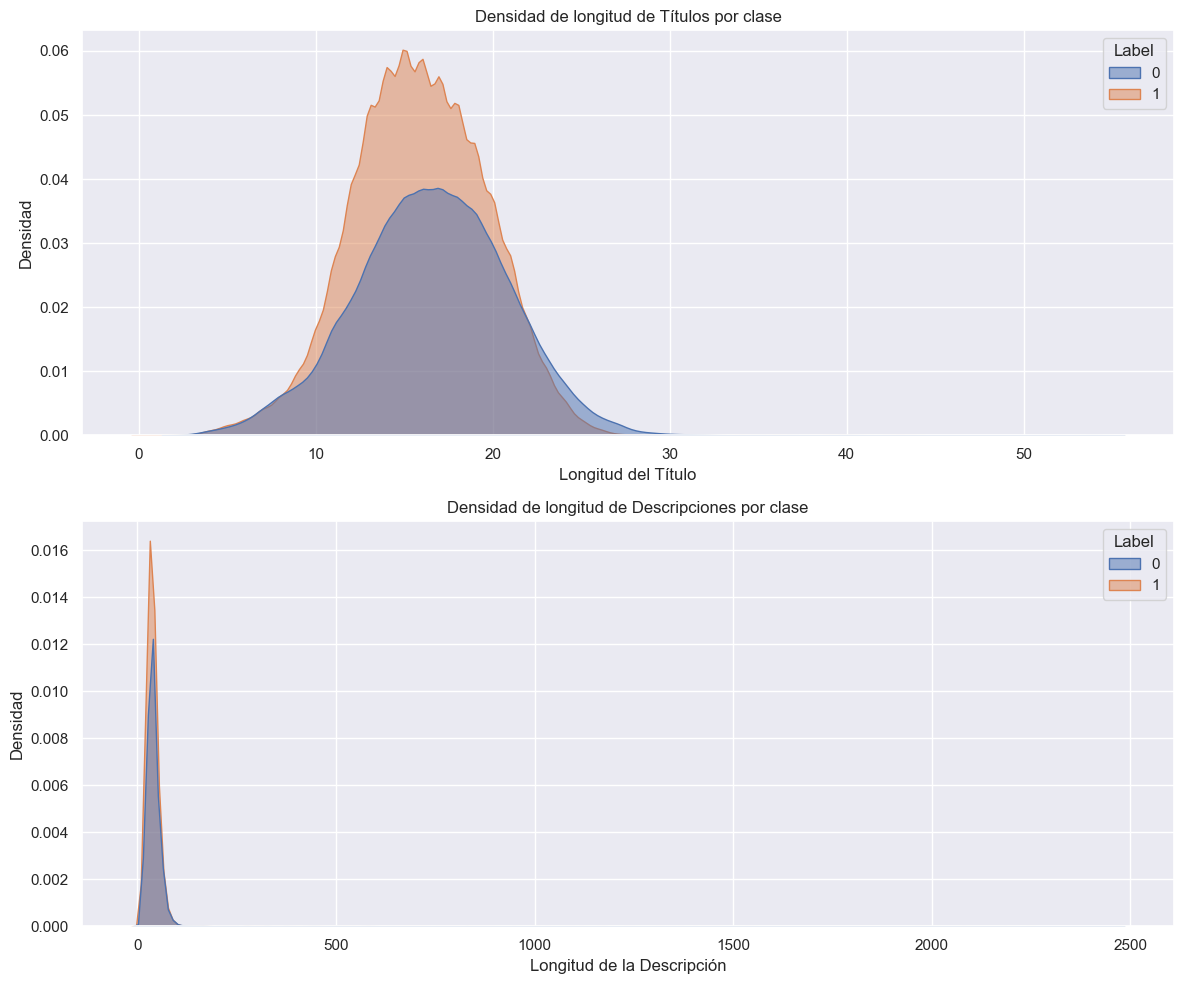

In [85]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

sns.histplot(
    data=df,
    x='Titulo_length',
    hue='Label',
    multiple="layer",
    ax=ax1,
    alpha=0.6
)
ax1.set_title('Distribución de longitud de Títulos por clase')
ax1.set_xlabel('Longitud del Título')
ax1.set_ylabel('Frecuencia')

sns.histplot(
    data=df,
    x='Descripcion_length',
    hue='Label',
    multiple="layer",
    ax=ax2,
    alpha=0.6
)
ax2.set_title('Distribución de longitud de Descripciones por clase')
ax2.set_xlabel('Longitud de la Descripción')
ax2.set_ylabel('Frecuencia')

plt.tight_layout()

plt.show()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

sns.kdeplot(
    data=df,
    x='Titulo_length',
    hue='Label',
    ax=ax1,
    fill=True,
    alpha=0.5
)
ax1.set_title('Densidad de longitud de Títulos por clase')
ax1.set_xlabel('Longitud del Título')
ax1.set_ylabel('Densidad')

sns.kdeplot(
    data=df,
    x='Descripcion_length',
    hue='Label',
    ax=ax2,
    fill=True,
    alpha=0.5
)
ax2.set_title('Densidad de longitud de Descripciones por clase')
ax2.set_xlabel('Longitud de la Descripción')
ax2.set_ylabel('Densidad')

plt.tight_layout()

plt.show()

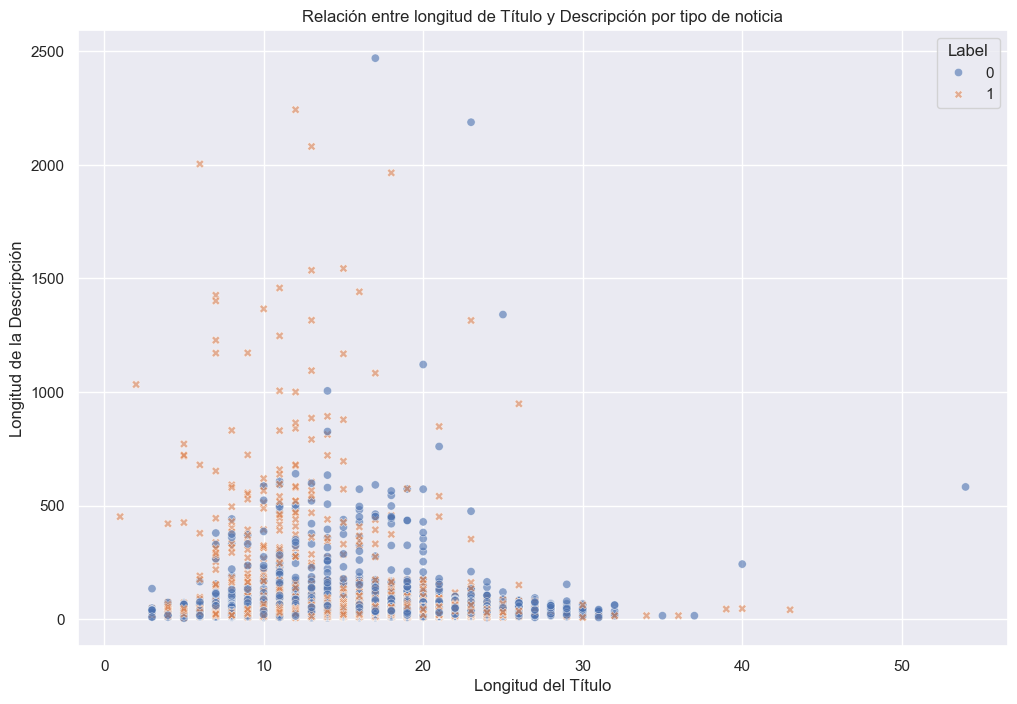

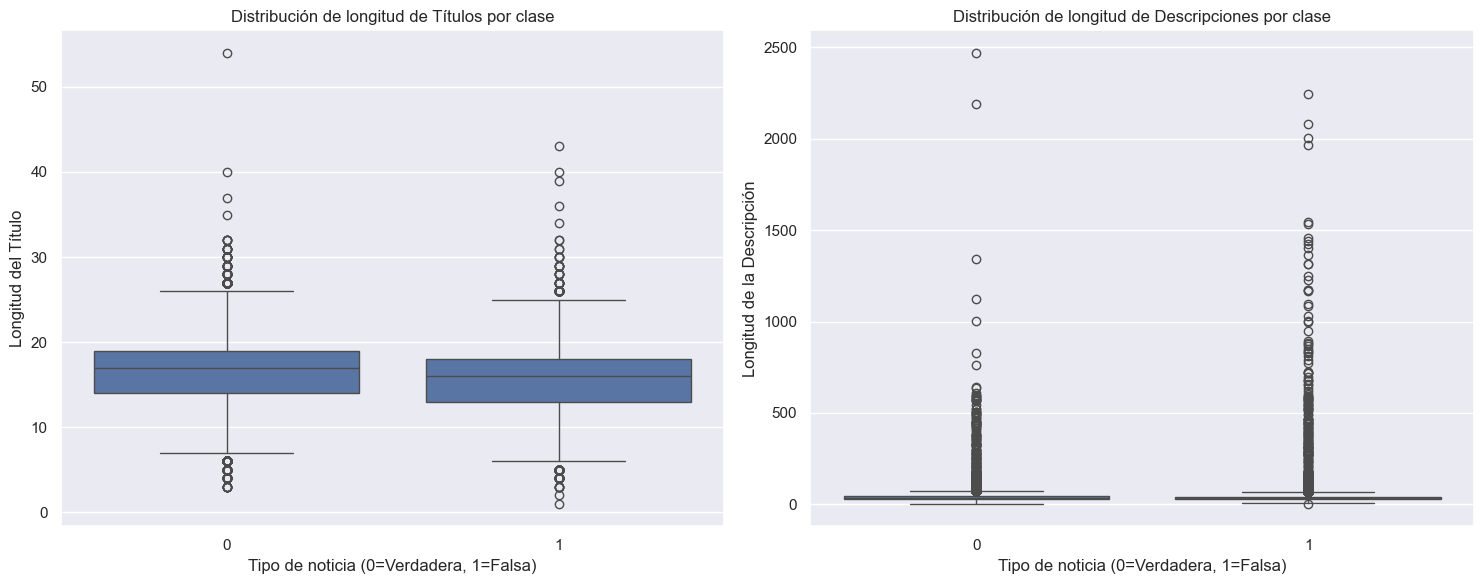

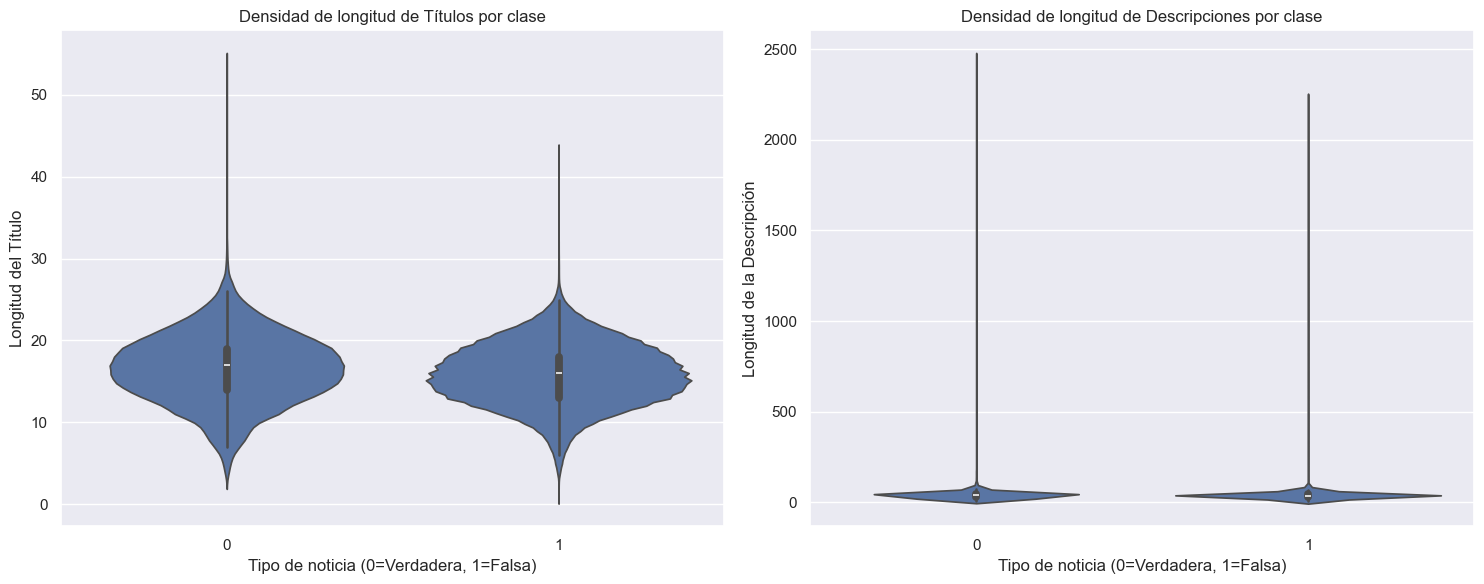


Estadísticas descriptivas por clase:

Longitud de Títulos:
         count       mean       std  min   25%   50%   75%   max
Label                                                           
0      23880.0  16.522111  4.244517  3.0  14.0  17.0  19.0  54.0
1      32738.0  15.863614  3.738031  1.0  13.0  16.0  18.0  43.0

Longitud de Descripciones:
         count       mean        std  min   25%   50%   75%     max
Label                                                              
0      23880.0  40.898409  38.214242  4.0  29.0  37.0  46.0  2470.0
1      32738.0  39.840827  49.393398  4.0  28.0  36.0  43.0  2243.0


In [86]:
# 1. Gráfico de dispersión (Scatter plot)
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df,
    x='Titulo_length',
    y='Descripcion_length',
    hue='Label',
    alpha=0.6,
    style='Label'
)
plt.title('Relación entre longitud de Título y Descripción por tipo de noticia')
plt.xlabel('Longitud del Título')
plt.ylabel('Longitud de la Descripción')
plt.show()

# 2. Box plots para ver la distribución
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Box plot para longitud de títulos
sns.boxplot(
    data=df,
    x='Label',
    y='Titulo_length',
    ax=ax1
)
ax1.set_title('Distribución de longitud de Títulos por clase')
ax1.set_xlabel('Tipo de noticia (0=Verdadera, 1=Falsa)')
ax1.set_ylabel('Longitud del Título')

# Box plot para longitud de descripciones
sns.boxplot(
    data=df,
    x='Label',
    y='Descripcion_length',
    ax=ax2
)
ax2.set_title('Distribución de longitud de Descripciones por clase')
ax2.set_xlabel('Tipo de noticia (0=Verdadera, 1=Falsa)')
ax2.set_ylabel('Longitud de la Descripción')

plt.tight_layout()
plt.show()

# 3. Violin plots para ver la densidad
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Violin plot para longitud de títulos
sns.violinplot(
    data=df,
    x='Label',
    y='Titulo_length',
    ax=ax1
)
ax1.set_title('Densidad de longitud de Títulos por clase')
ax1.set_xlabel('Tipo de noticia (0=Verdadera, 1=Falsa)')
ax1.set_ylabel('Longitud del Título')

# Violin plot para longitud de descripciones
sns.violinplot(
    data=df,
    x='Label',
    y='Descripcion_length',
    ax=ax2
)
ax2.set_title('Densidad de longitud de Descripciones por clase')
ax2.set_xlabel('Tipo de noticia (0=Verdadera, 1=Falsa)')
ax2.set_ylabel('Longitud de la Descripción')

plt.tight_layout()
plt.show()

# 4. Estadísticas descriptivas
print("\nEstadísticas descriptivas por clase:")
print("\nLongitud de Títulos:")
print(df.groupby('Label')['Titulo_length'].describe())
print("\nLongitud de Descripciones:")
print(df.groupby('Label')['Descripcion_length'].describe())

Con estas graficas y estadisticas lo que estabamos tratando de observar era si hay alguna relacion entre las longitudes del titulo y las descripciones y si la noticia es falsa o no, a juzgar principalmente por el scatter plot y diagramas de cajas, no se observa ningun patron ni variación.

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sergiofranco/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<Figure size 2000x1500 with 0 Axes>

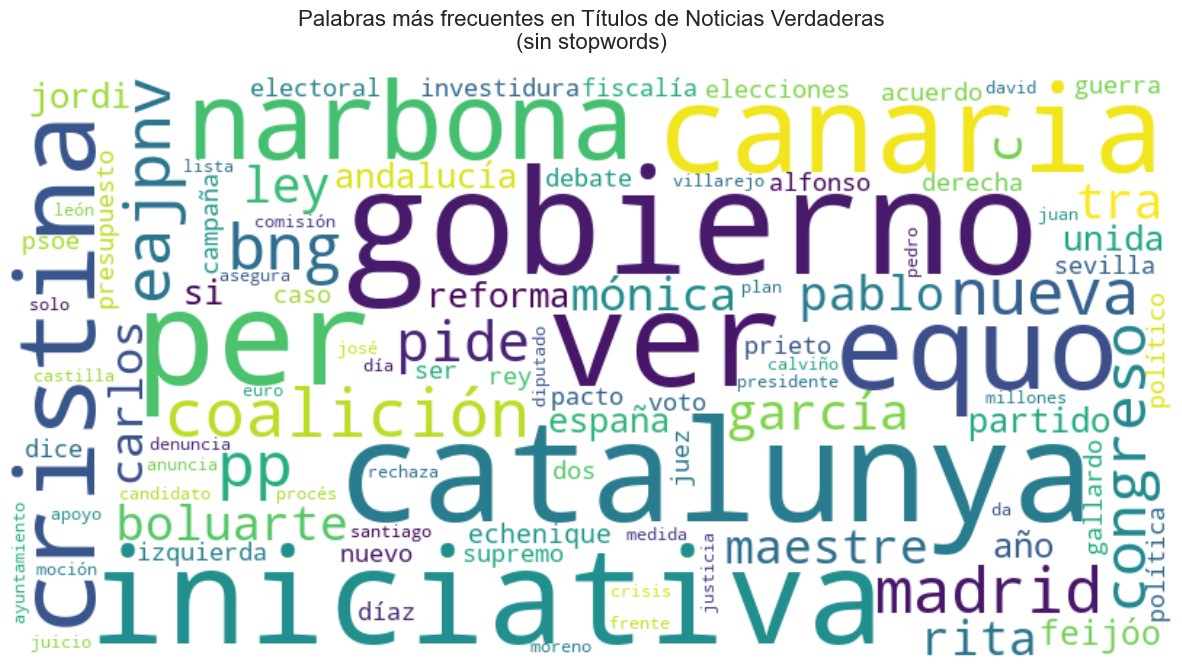

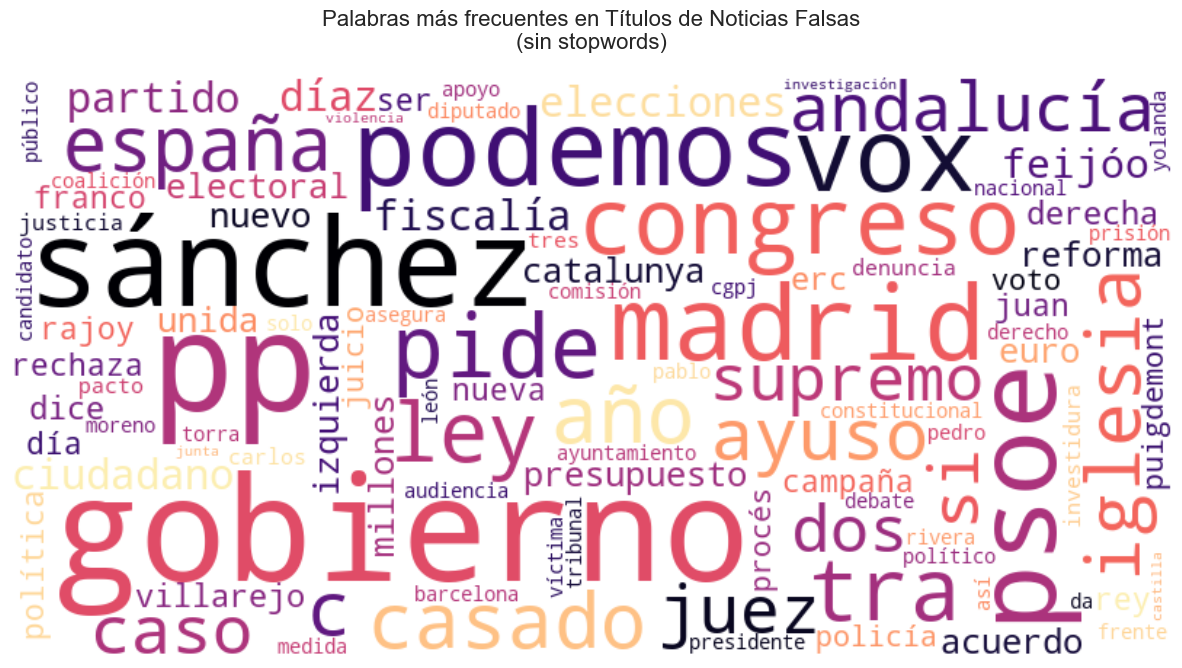

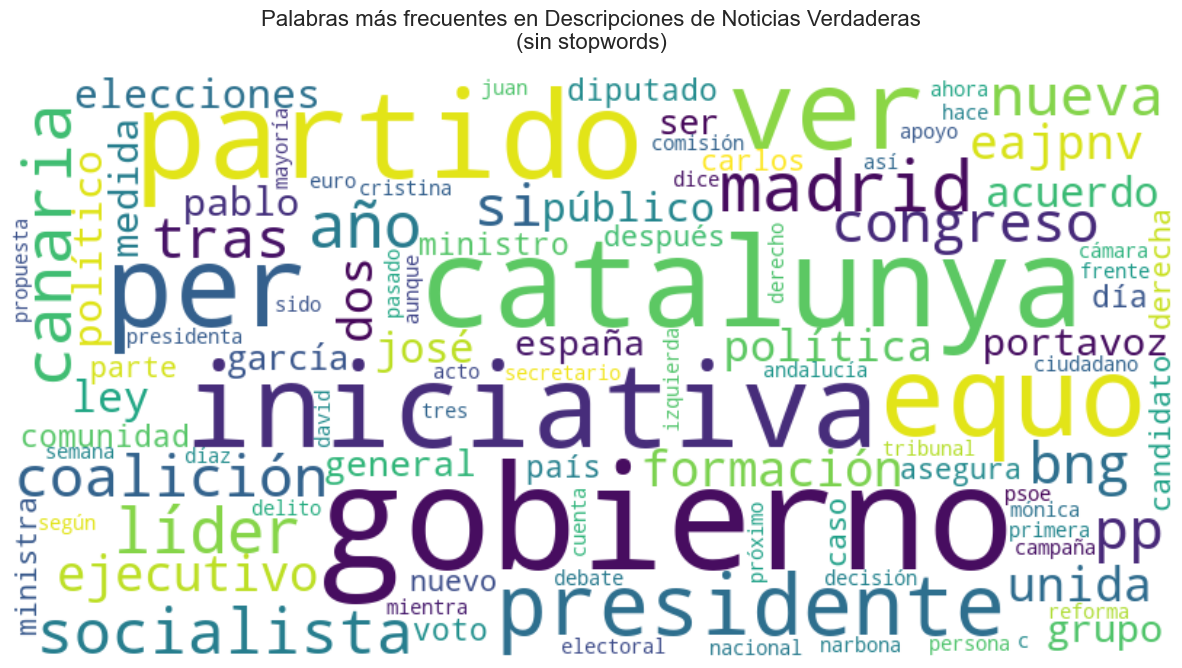

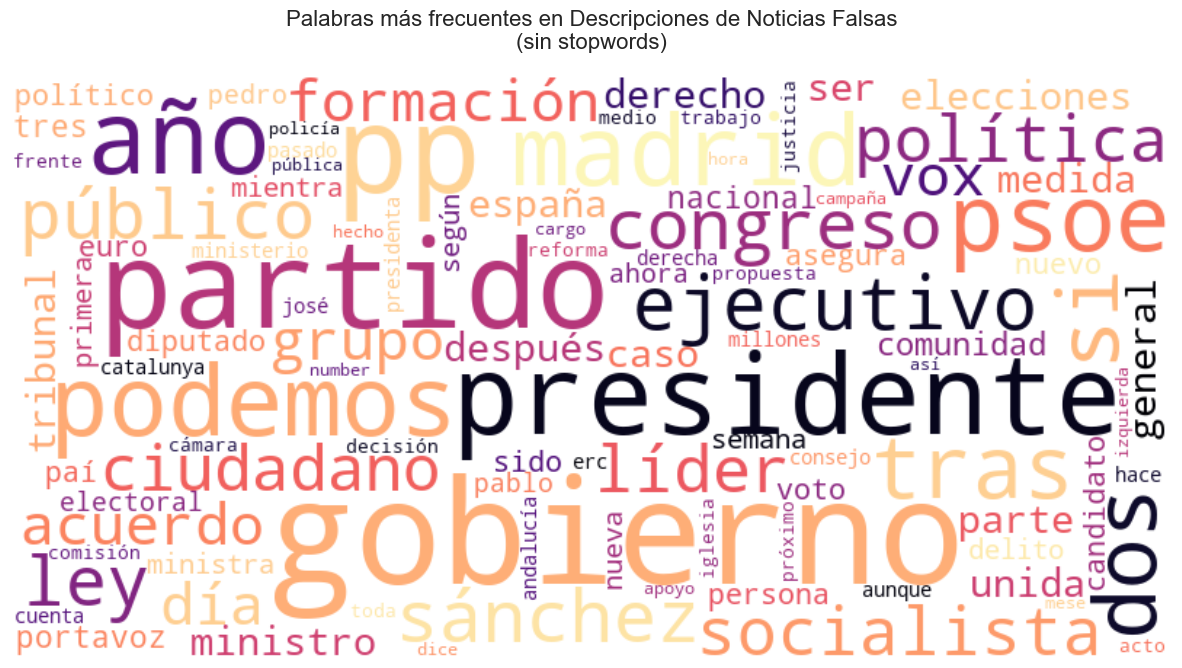

In [87]:
nltk.download('stopwords')

# Obtener stopwords en español e inglés
stop_words = list(set(stopwords.words('spanish') + stopwords.words('english')))

def limpiar_texto(texto):
    """
    Función para limpiar texto: convertir a minúsculas,
    eliminar signos de puntuación y stopwords
    """
    # Convertir a minúsculas
    texto = texto.lower()
    # Eliminar signos de puntuación y números
    texto = re.sub(r'[^\w\s]', '', texto)
    texto = re.sub(r'\d+', '', texto)
    # Dividir en palabras
    palabras = texto.split()
    # Eliminar stopwords
    palabras_limpiadas = [palabra for palabra in palabras if palabra not in stop_words]
    return ' '.join(palabras_limpiadas)

def crear_wordcloud(texto, titulo, color='viridis'):
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap=color,
        max_words=100,
        collocations=False,
        min_font_size=10,
        max_font_size=100
    ).generate(texto)

    plt.figure(figsize=(15, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(titulo, fontsize=16, pad=20)
    plt.show()

# Crear una copia del dataframe
df_clean = df.copy()

# Limpiar textos
df_clean['Titulo_limpio'] = df_clean['Titulo'].astype(str).apply(limpiar_texto)
df_clean['Descripcion_limpia'] = df_clean['Descripcion'].astype(str).apply(limpiar_texto)

# Separar noticias verdaderas y falsas
noticias_verdaderas = df_clean[df_clean['Label'] == 0]
noticias_falsas = df_clean[df_clean['Label'] == 1]

# Preparar textos limpios para wordcloud
texto_titulos_verdaderos = ' '.join(noticias_verdaderas['Titulo_limpio'])
texto_titulos_falsos = ' '.join(noticias_falsas['Titulo_limpio'])
texto_desc_verdaderas = ' '.join(noticias_verdaderas['Descripcion_limpia'])
texto_desc_falsas = ' '.join(noticias_falsas['Descripcion_limpia'])

# Crear los wordclouds
plt.figure(figsize=(20, 15))

# Wordcloud para títulos de noticias verdaderas
crear_wordcloud(
    texto_titulos_verdaderos,
    'Palabras más frecuentes en Títulos de Noticias Verdaderas\n(sin stopwords)',
    'viridis'
)

# Wordcloud para títulos de noticias falsas

crear_wordcloud(
    texto_titulos_falsos,
    'Palabras más frecuentes en Títulos de Noticias Falsas\n(sin stopwords)',
    'magma'
)

# Wordcloud para descripciones de noticias verdaderas

crear_wordcloud(
    texto_desc_verdaderas,
    'Palabras más frecuentes en Descripciones de Noticias Verdaderas\n(sin stopwords)',
    'viridis'
)

# Wordcloud para descripciones de noticias falsas

crear_wordcloud(
    texto_desc_falsas,
    'Palabras más frecuentes en Descripciones de Noticias Falsas\n(sin stopwords)',
    'magma'
)

Es posible observar que sí hay unas palabras que se repiten más que otras, también desde estas graficas podemos observar que los temas más controversiales son politica y religión, lo que puede ser familiar y de esperarse.

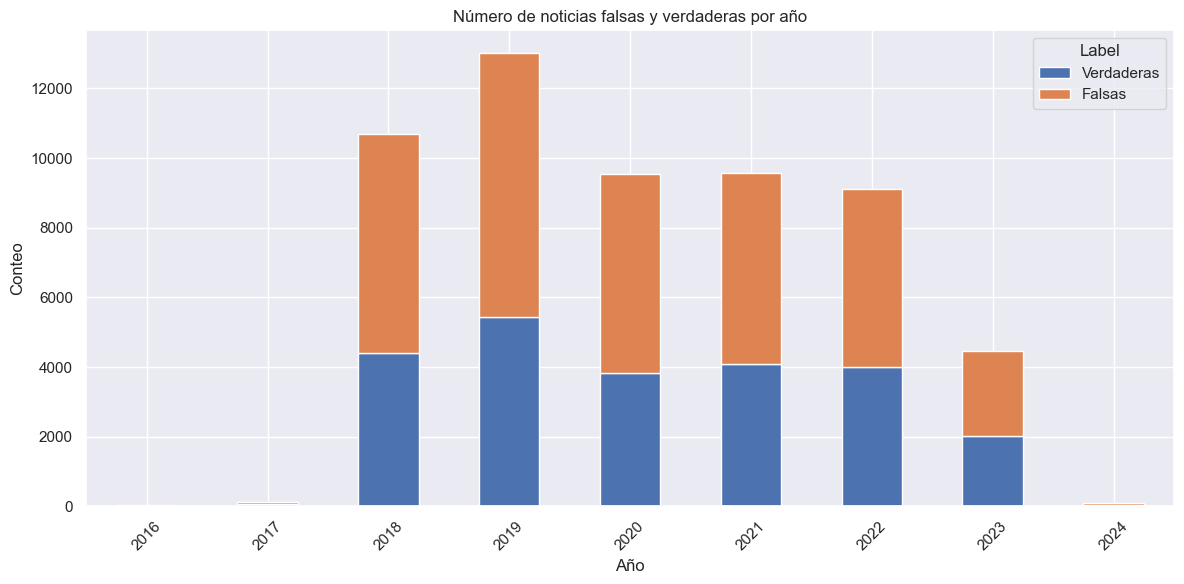

In [88]:
df['Year'] = pd.to_datetime(df['Fecha'], format='%d/%m/%Y').dt.year

news_per_year = df.groupby(['Year', 'Label']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
news_per_year.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Número de noticias falsas y verdaderas por año')
plt.xlabel('Año')
plt.ylabel('Conteo')
plt.legend(title='Label', labels=['Verdaderas', 'Falsas'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

2019 fue un año en el que las noticias falsas fueron un problema importante, al igual que en años anteriores y posteriores.

Algunos ejemplos de noticias falsas que circularon en 2019:

- Incendios en el Amazonas: Se difundieron imágenes de incendios antiguos o de otros lugares como si fueran del Amazonas, con la intención de crear alarma y desinformación.
- Protestas en Chile: Se difundieron noticias falsas sobre supuestos saqueos y violencia en las protestas, con la intención de generar miedo y deslegitimar las manifestaciones.
- Elecciones en Estados Unidos: Se difundieron noticias falsas sobre fraude electoral y manipulación de votos, con la intención de influir en la opinión pública y desacreditar el proceso electoral.

Más sobre esto en: https://avaazimages.avaaz.org/US_2020_report_1105_v04.pdf

In [89]:
from nltk.util import ngrams
import nltk
from nltk.corpus import stopwords
from collections import Counter

# Obtener stopwords en español
stop_words = list(set(stopwords.words('spanish') + stopwords.words('english')))

# Function to generate n-grams
def generate_ngrams(text, n):
    # Dividir en palabras y filtrar stopwords
    words = [word for word in text.split() if word.lower() not in stop_words]
    n_grams = ngrams(words, n)
    return [' '.join(grams) for grams in n_grams]

# Generar columnas de n-gramas para Titulo y Descripcion
df['Titulo_bigrams'] = df['Titulo'].apply(lambda x: generate_ngrams(x, 2))
df['Titulo_trigrams'] = df['Titulo'].apply(lambda x: generate_ngrams(x, 3))
df['Descripcion_bigrams'] = df['Descripcion'].apply(lambda x: generate_ngrams(x, 2))
df['Descripcion_trigrams'] = df['Descripcion'].apply(lambda x: generate_ngrams(x, 3))

# Dividir en noticias falsas y verdaderas
df_fake = df[df['Label'] == 1]
df_real = df[df['Label'] == 0]

# Contadores para noticias FALSAS
fake_titulo_bigrams = Counter([bg for sublist in df_fake['Titulo_bigrams'] for bg in sublist])
fake_titulo_trigrams = Counter([tg for sublist in df_fake['Titulo_trigrams'] for tg in sublist])
fake_descripcion_bigrams = Counter([bg for sublist in df_fake['Descripcion_bigrams'] for bg in sublist])
fake_descripcion_trigrams = Counter([tg for sublist in df_fake['Descripcion_trigrams'] for tg in sublist])

# Contadores para noticias VERDADERAS
real_titulo_bigrams = Counter([bg for sublist in df_real['Titulo_bigrams'] for bg in sublist])
real_titulo_trigrams = Counter([tg for sublist in df_real['Titulo_trigrams'] for tg in sublist])
real_descripcion_bigrams = Counter([bg for sublist in df_real['Descripcion_bigrams'] for bg in sublist])
real_descripcion_trigrams = Counter([tg for sublist in df_real['Descripcion_trigrams'] for tg in sublist])

# Obtener los 10 más comunes
top_fake_titulo_bigrams = fake_titulo_bigrams.most_common(10)
top_fake_titulo_trigrams = fake_titulo_trigrams.most_common(10)
top_fake_descripcion_bigrams = fake_descripcion_bigrams.most_common(10)
top_fake_descripcion_trigrams = fake_descripcion_trigrams.most_common(10)

top_real_titulo_bigrams = real_titulo_bigrams.most_common(10)
top_real_titulo_trigrams = real_titulo_trigrams.most_common(10)
top_real_descripcion_bigrams = real_descripcion_bigrams.most_common(10)
top_real_descripcion_trigrams = real_descripcion_trigrams.most_common(10)

# Imprimir resultados
print("=== TOP 10 BIGRAMAS - NOTICIAS FALSAS (TITULO) ===")
print(top_fake_titulo_bigrams)

print("\n=== TOP 10 TRIGRAMAS - NOTICIAS FALSAS (TITULO) ===")
print(top_fake_titulo_trigrams)

print("\n=== TOP 10 BIGRAMAS - NOTICIAS FALSAS (DESCRIPCION) ===")
print(top_fake_descripcion_bigrams)

print("\n=== TOP 10 TRIGRAMAS - NOTICIAS FALSAS (DESCRIPCION) ===")
print(top_fake_descripcion_trigrams)

print("\n=== TOP 10 BIGRAMAS - NOTICIAS VERDADERAS (TITULO) ===")
print(top_real_titulo_bigrams)

print("\n=== TOP 10 TRIGRAMAS - NOTICIAS VERDADERAS (TITULO) ===")
print(top_real_titulo_trigrams)

print("\n=== TOP 10 BIGRAMAS - NOTICIAS VERDADERAS (DESCRIPCION) ===")
print(top_real_descripcion_bigrams)

print("\n=== TOP 10 TRIGRAMAS - NOTICIAS VERDADERAS (DESCRIPCION) ===")
print(top_real_descripcion_trigrams)


=== TOP 10 BIGRAMAS - NOTICIAS FALSAS (TITULO) ===
[('Unidas Podemos', 523), ('Juan Carlos', 386), ('Castilla León', 270), ('Yolanda Díaz', 269), ('PP Cs', 251), ('Pedro Sánchez', 245), ('Audiencia Nacional', 236), ('Comunidad Madrid', 194), ('reforma laboral', 168), ('Pablo Iglesias', 168)]

=== TOP 10 TRIGRAMAS - NOTICIAS FALSAS (TITULO) ===
[('PSOE Unidas Podemos', 95), ("ley 'solo sí'", 92), ('rey Juan Carlos', 66), ('PP, Cs Vox', 55), ('Gobierno PP Cs', 34), ('Unidas Podemos pide', 32), ('Fundación Francisco Franco', 30), ('da luz verde', 26), ('financiación ilegal PP', 25), ('caja B PP', 24)]

=== TOP 10 BIGRAMAS - NOTICIAS FALSAS (DESCRIPCION) ===
[('Unidas Podemos', 777), ('presidente Gobierno', 721), ('Pedro Sánchez', 557), ('Comunidad Madrid', 456), ('secretario general', 394), ('Audiencia Nacional', 310), ('líder PP', 296), ('Juan Carlos', 291), ('Consejo Ministros', 287), ('formación morada', 263)]

=== TOP 10 TRIGRAMAS - NOTICIAS FALSAS (DESCRIPCION) ===
[('presidenta Comu

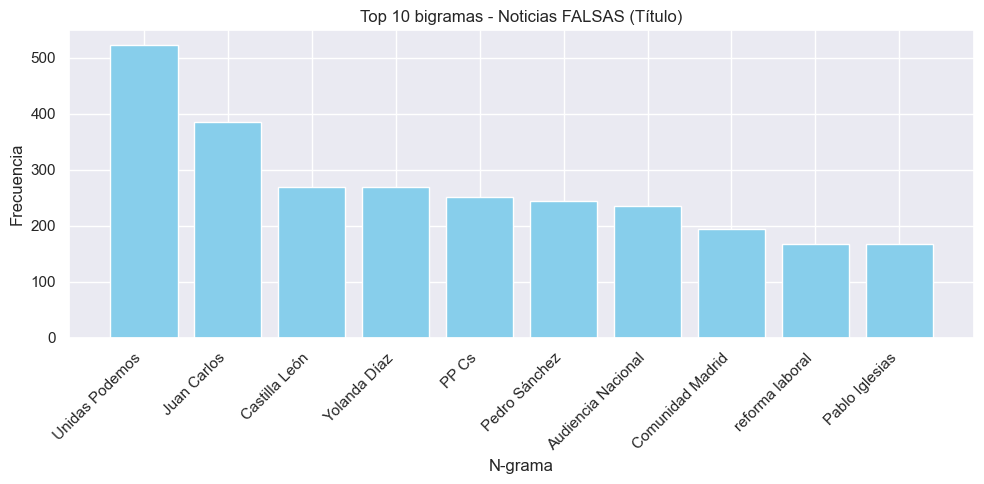

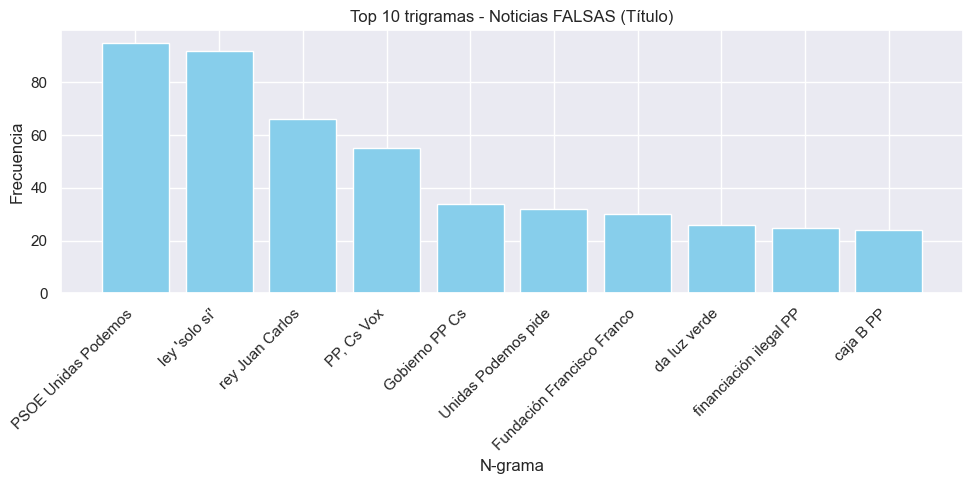

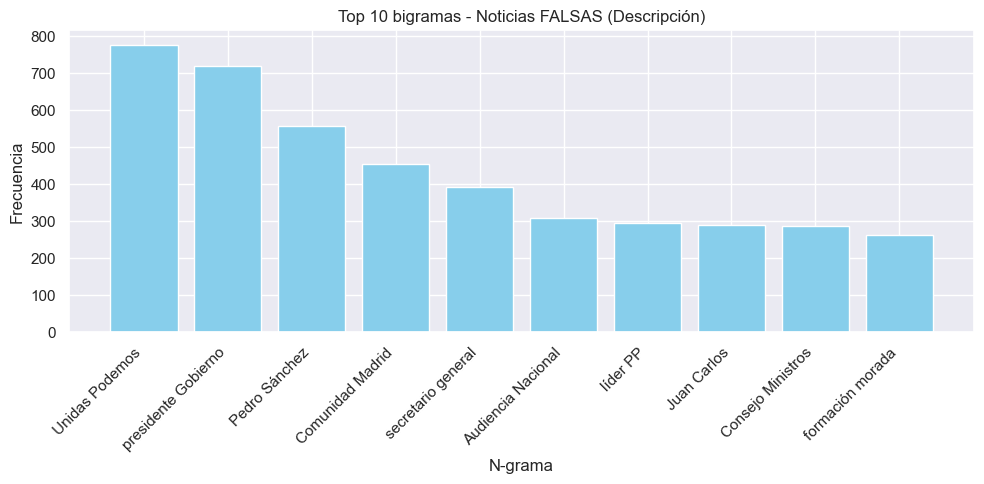

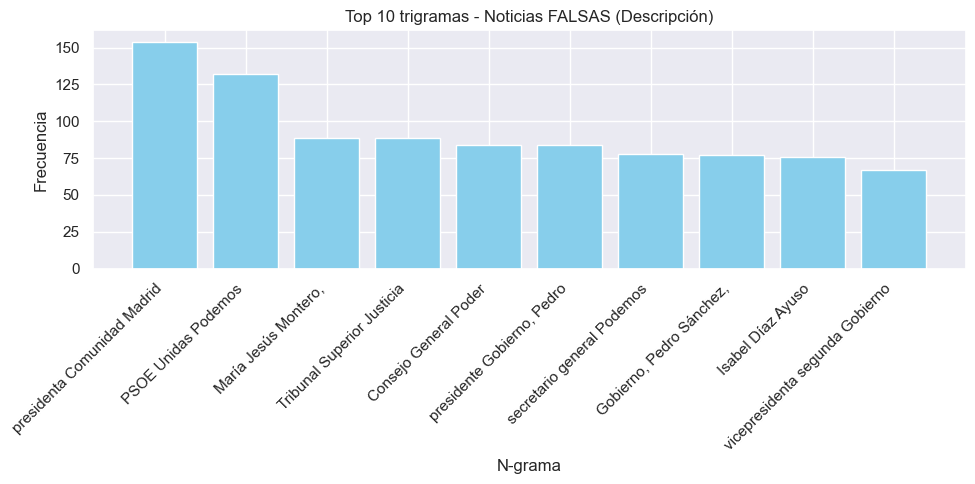

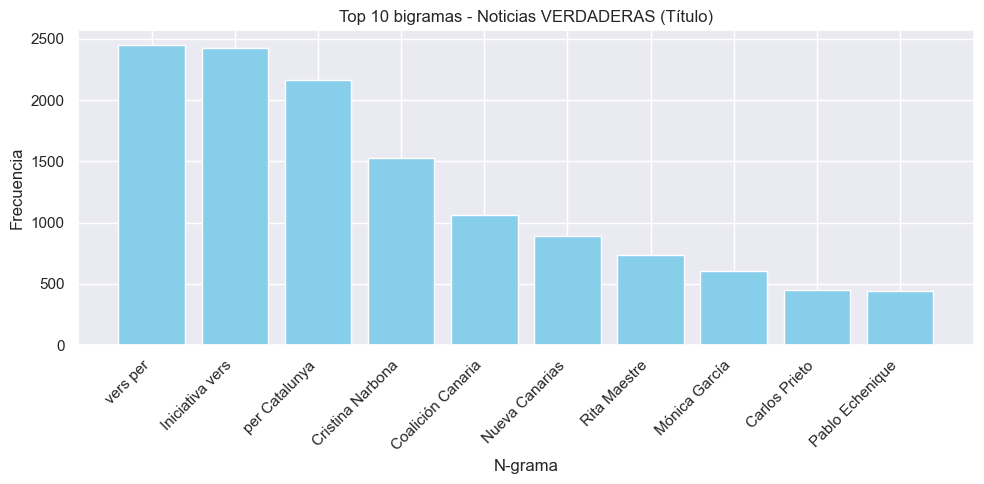

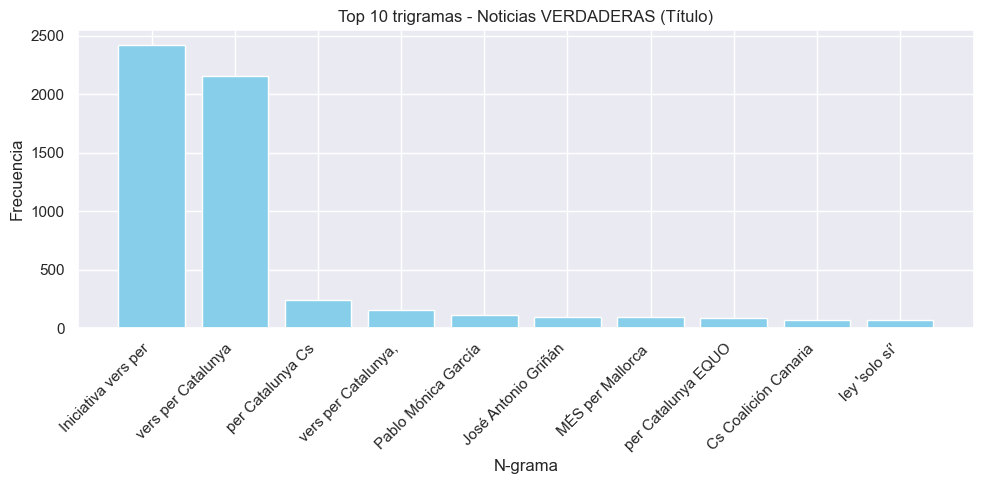

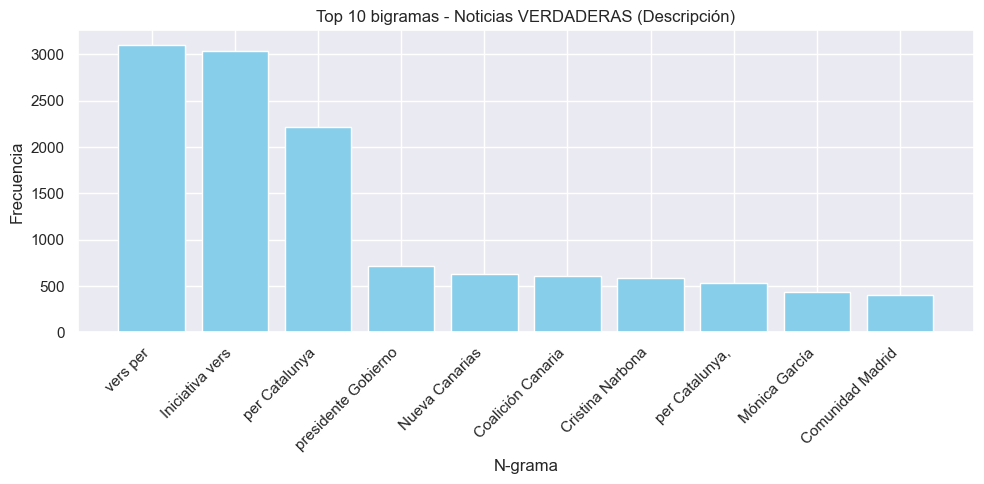

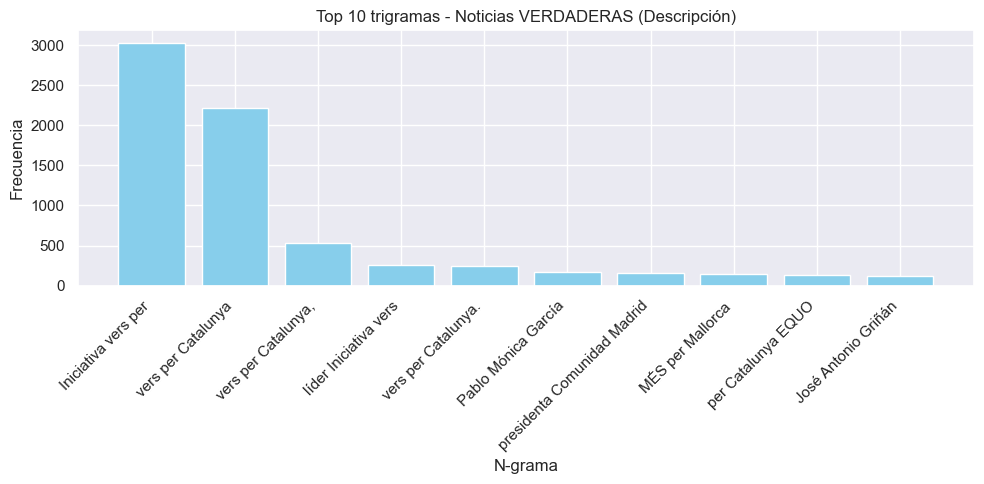

In [90]:
def plot_ngrams(top_ngrams, title):
    """
    Recibe una lista de tuplas (ngram, frecuencia)
    y un título para la gráfica.
    """
    # Separar los n-gramas y sus frecuencias
    ngrams_list = [item[0] for item in top_ngrams]
    freqs = [item[1] for item in top_ngrams]

    # Crear la figura
    plt.figure(figsize=(10, 5))
    plt.bar(ngrams_list, freqs, color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.title(title)
    plt.xlabel("N-grama")
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

# EJEMPLOS DE USO:

# 1. BIGRAMAS NOTICIAS FALSAS (TITULO)
plot_ngrams(top_fake_titulo_bigrams, "Top 10 bigramas - Noticias FALSAS (Título)")

# 2. TRIGRAMAS NOTICIAS FALSAS (TITULO)
plot_ngrams(top_fake_titulo_trigrams, "Top 10 trigramas - Noticias FALSAS (Título)")

# 3. BIGRAMAS NOTICIAS FALSAS (DESCRIPCION)
plot_ngrams(top_fake_descripcion_bigrams, "Top 10 bigramas - Noticias FALSAS (Descripción)")

# 4. TRIGRAMAS NOTICIAS FALSAS (DESCRIPCION)
plot_ngrams(top_fake_descripcion_trigrams, "Top 10 trigramas - Noticias FALSAS (Descripción)")

# 5. BIGRAMAS NOTICIAS VERDADERAS (TITULO)
plot_ngrams(top_real_titulo_bigrams, "Top 10 bigramas - Noticias VERDADERAS (Título)")

# 6. TRIGRAMAS NOTICIAS VERDADERAS (TITULO)
plot_ngrams(top_real_titulo_trigrams, "Top 10 trigramas - Noticias VERDADERAS (Título)")

# 7. BIGRAMAS NOTICIAS VERDADERAS (DESCRIPCION)
plot_ngrams(top_real_descripcion_bigrams, "Top 10 bigramas - Noticias VERDADERAS (Descripción)")

# 8. TRIGRAMAS NOTICIAS VERDADERAS (DESCRIPCION)
plot_ngrams(top_real_descripcion_trigrams, "Top 10 trigramas - Noticias VERDADERAS (Descripción)")


Esta in formación nos puede dar más contexto y peso a lo que son noticias falsas y verdaderas dentro del modelo, es información relevante tanto para el analisis anterior como para el modelo, por ellos, serán incluidas en nuestros clasificadores.

# 2. Transformaciones (stemming, nulos, normalizaciones y ngramas)

In [91]:
def replace_nan_with_description_array(X):
    df = pd.DataFrame(X, columns=['Titulo', 'Descripcion', 'Fecha'])  # reconstruir el df
    df = replace_nan_with_description(df)
    return df

nan_replacer = FunctionTransformer(replace_nan_with_description_array, validate=False)

In [92]:
from sklearn.base import BaseEstimator, TransformerMixin
class NGramsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_grams=[2, 3]):  # contaremos con bigramas y trigramas
        self.n_grams = n_grams

    def generate_ngrams(self, text, n):
        if isinstance(text, str):
            words = [word for word in text.split() if word not in stop_words]
            n_grams = ngrams(words, n)
            return [' '.join(grams) for grams in n_grams]
        return []

    def transform(self, X, y=None):
        df = X.copy()
        for n in self.n_grams:
            df[f'Titulo_{n}grams'] = df['Titulo'].apply(lambda x: self.generate_ngrams(x, n))
            df[f'Descripcion_{n}grams'] = df['Descripcion'].apply(lambda x: self.generate_ngrams(x, n))
        return df

    def fit(self, X, y=None):
        return self

In [93]:
class SentimentTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.analyzer = create_analyzer(task="sentiment", lang="es")

    def get_sentiment_info(self, text):
        """
        Aplica el analizador de sentimiento a un texto.
        Retorna (label, probabilidades).
        """
        if not isinstance(text, str):
            text = "" 
        prediction = self.analyzer.predict(text)
        return prediction.output, prediction.probas

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        """
        X es un DataFrame que debe tener al menos las columnas 'Titulo' y 'Descripcion'.
        """
        df = X.copy()

        df["sentiment_result"] = df["Titulo"].apply(lambda x: self.get_sentiment_info(x)[0])
        df["sentiment_prob"] = df["Titulo"].apply(lambda x: self.get_sentiment_info(x)[1])

        df["sentiment_prob_neg"] = df["sentiment_prob"].apply(lambda d: d["NEG"])
        df["sentiment_prob_neu"] = df["sentiment_prob"].apply(lambda d: d["NEU"])
        df["sentiment_prob_pos"] = df["sentiment_prob"].apply(lambda d: d["POS"])

        df.drop(columns=['sentiment_prob', 'sentiment_result'], inplace=True)

        return df


In [94]:
port_stem = PorterStemmer()

class StemmingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def stem_text(self, content):
        if isinstance(content, str):
            # Eliminar caracteres no alfabeticos
            content = re.sub(r'[^a-zA-Z]', ' ', content)
            content = content.lower()
            # Palabras tokenizadas
            words = content.split()
            # Stemming y eliminar stopwords
            stemmed_words = [port_stem.stem(word) for word in words if word not in stop_words]
            return " ".join(stemmed_words)
        return ""

    def transform(self, X, y=None):
        df = X.copy()
        df['Titulo'] = df['Titulo'].apply(self.stem_text)
        df['Descripcion'] = df['Descripcion'].apply(self.stem_text)
        return df

    def fit(self, X, y=None):
        return self  # No fitting needed

# 3. Entrenamientos y evaluacion del modelo

##KNeighborsClassifier

In [95]:
df = pd.read_csv('./train.csv', delimiter=';')

In [96]:
X_train = df[['Titulo', 'Descripcion', 'Fecha']]
y_train = df['Label']

In [97]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

preprocessor = ColumnTransformer(
    transformers=[
        ('titulo_tfidf', TfidfVectorizer(smooth_idf=False), 'Titulo'),
        ('desc_tfidf', TfidfVectorizer(smooth_idf=False), 'Descripcion')
    ],
    remainder='drop'
)

pipeline = Pipeline([
    ('nan_replacer', nan_replacer),
    ('stemmer', StemmingTransformer()),
    ('ngrams', NGramsTransformer()),
    ("sentiment", SentimentTransformer()),
    ('preprocessor', preprocessor),
    ('knn', KNeighborsClassifier(n_neighbors=21, weights='distance'))
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('nan_replacer',
                 FunctionTransformer(func=<function replace_nan_with_description_array at 0x31f4591c0>)),
                ('stemmer', StemmingTransformer()),
                ('ngrams', NGramsTransformer()),
                ('sentiment', SentimentTransformer()),
                ('preprocessor',
                 ColumnTransformer(transformers=[('titulo_tfidf',
                                                  TfidfVectorizer(smooth_idf=False),
                                                  'Titulo'),
                                                 ('desc_tfidf',
                                                  TfidfVectorizer(smooth_idf=False),
                                                  'Descripcion')])),
                ('knn',
                 KNeighborsClassifier(n_neighbors=21, weights='distance'))])

##Naive Bayes

In [98]:
df = pd.read_csv('./train.csv', delimiter=';')

In [99]:
X_train = df[['Titulo', 'Descripcion', 'Fecha']]
y_train = df['Label']

In [100]:
from sklearn.naive_bayes import MultinomialNB

# Create the new pipeline with Naïve Bayes
pipeline_nb = Pipeline([
    ('nan_replacer', nan_replacer),
    ('stemmer', StemmingTransformer()),
    ('ngrams', NGramsTransformer()),
    ("sentiment", SentimentTransformer()),
    ('preprocessor', preprocessor),
    ('nb', MultinomialNB(alpha=3.0))  # Replace KNN with Naïve Bayes
])

# Train the pipeline
pipeline_nb.fit(X_train, y_train)

Pipeline(steps=[('nan_replacer',
                 FunctionTransformer(func=<function replace_nan_with_description_array at 0x31f4591c0>)),
                ('stemmer', StemmingTransformer()),
                ('ngrams', NGramsTransformer()),
                ('sentiment', SentimentTransformer()),
                ('preprocessor',
                 ColumnTransformer(transformers=[('titulo_tfidf',
                                                  TfidfVectorizer(smooth_idf=False),
                                                  'Titulo'),
                                                 ('desc_tfidf',
                                                  TfidfVectorizer(smooth_idf=False),
                                                  'Descripcion')])),
                ('nb', MultinomialNB(alpha=3.0))])

##Decision Tree Clasifier

In [101]:
df = pd.read_csv('./train.csv', delimiter=';')

In [102]:
X_train = df[['Titulo', 'Descripcion', 'Fecha']]
y_train = df['Label']

In [103]:
from sklearn.tree import DecisionTreeClassifier

pipeline_dt = Pipeline([
    ('nan_replacer', nan_replacer),
    ('stemmer', StemmingTransformer()),
    ('ngrams', NGramsTransformer()),
    ("sentiment", SentimentTransformer()),
    ('preprocessor', preprocessor), 
    ('decision_tree', DecisionTreeClassifier(max_depth=640, min_samples_split=64))  # Decision Tree Classifier
])

pipeline_dt.fit(X_train, y_train)

Pipeline(steps=[('nan_replacer',
                 FunctionTransformer(func=<function replace_nan_with_description_array at 0x31f4591c0>)),
                ('stemmer', StemmingTransformer()),
                ('ngrams', NGramsTransformer()),
                ('sentiment', SentimentTransformer()),
                ('preprocessor',
                 ColumnTransformer(transformers=[('titulo_tfidf',
                                                  TfidfVectorizer(smooth_idf=False),
                                                  'Titulo'),
                                                 ('desc_tfidf',
                                                  TfidfVectorizer(smooth_idf=False),
                                                  'Descripcion')])),
                ('decision_tree',
                 DecisionTreeClassifier(max_depth=640, min_samples_split=64))])

In [104]:
df = pd.read_csv('./train.csv', delimiter=';')

In [105]:
X_test = df[['Titulo', 'Descripcion', 'Fecha']]

In [106]:
y_test = df['Label']

In [107]:
y_pred_knn = pipeline.predict(X_test)
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))

KNN Accuracy: 0.9999824755095246


In [ ]:
y_pred_nb = pipeline_nb.predict(X_test)
print("Naïve Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))

In [ ]:
y_pred_dt = pipeline_dt.predict(X_test)
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))

Decision Tree Accuracy: 0.9620244291397227


In [ ]:
resultados = []

modelos = [
    ("KNN", pipeline, y_pred_knn),
    ("Naive Bayes", pipeline_nb, y_pred_nb),
    ("Decision Tree", pipeline_dt, y_pred_dt)
]

for nombre_modelo, pipeline, y_pred in modelos:
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)   # Para binario usa por defecto average='binary'
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Agregar los resultados a la lista
    resultados.append([nombre_modelo, acc, prec, rec, f1])

df_resultados = pd.DataFrame(resultados, columns=["Modelo", "Accuracy", "Precision", "Recall", "F1-Score"])

print(df_resultados)

          Modelo  Accuracy  Precision    Recall  F1-Score
0            KNN  0.999982   0.999970  1.000000  0.999985
1    Naive Bayes  0.839318   0.786929  0.992098  0.877683
2  Decision Tree  0.962024   0.966605  0.968092  0.967348


# 4. Predicciones

## 4.1 KNN

In [ ]:
df = pd.read_csv('./test', delimiter=';')
X_train = df[['Titulo', 'Descripcion', 'Fecha']]
y_pred = pipeline.predict(X_train)

df_transformed = pipeline[:4].transform(df)


df_merged = pd.concat([
    df.reset_index(drop=True),
    df_transformed.reset_index(drop=True)
], axis=1)


df_merged["Prediccion"] = y_pred

df_merged.to_csv("test_predicciones_knn.csv", index=False, sep=';')

## 4.2 NB

In [ ]:
df = pd.read_csv('./test', delimiter=';')
X_train = df[['Titulo', 'Descripcion', 'Fecha']]
y_pred = pipeline_nb.predict(X_train)

df_transformed = pipeline[:4].transform(df)


df_merged = pd.concat([
    df.reset_index(drop=True),
    df_transformed.reset_index(drop=True)
], axis=1)


df_merged["Prediccion"] = y_pred

df_merged.to_csv("test_predicciones_nb.csv", index=False, sep=';')

## 4.3 DT

In [ ]:
df = pd.read_csv('./test', delimiter=';')
X_train = df[['Titulo', 'Descripcion', 'Fecha']]
y_pred = pipeline_dt.predict(X_train)

df_transformed = pipeline[:4].transform(df)


df_merged = pd.concat([
    df.reset_index(drop=True),
    df_transformed.reset_index(drop=True)
], axis=1)


df_merged["Prediccion"] = y_pred

df_merged.to_csv("test_predicciones_dt.csv", index=False, sep=';')